In [445]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import requests
import json

# Get list of top coins

In [446]:
# Set the API endpoint URL
def get_top_coins(num_of_coins):
    
    url = "https://pro-api.coinmarketcap.com/v1/cryptocurrency/listings/latest"

    # Set the request parameters
    parameters = {
        "sort": "market_cap",  # Sort the data by market capitalization
        "sort_dir": "desc",  # Sort the data in descending order
        "limit": num_of_coins,  # The maximum number of data points to retrieve
        "convert": "USD",  # The currency to convert the prices to
    }

    # Set the API key
    headers = {
        "X-CMC_PRO_API_KEY": "f7885d33-cf7e-4c18-a14c-326c1c7de324"
    }

    # Make the request
    response = requests.get(url, headers=headers, params=parameters)


    data1 = json.loads(response.text)
    # Get the list of cryptocurrencies from the data
    cryptocurrencies = data1["data"]
    
    #Get list of coins
    global top_coins
    top_coins = []
    for idx, crypto in enumerate(cryptocurrencies):
        top_coins.append(cryptocurrencies[idx]['name'])
        
    return top_coins

In [447]:
list_to_exclude = ['Tether',
                  'USD Coin',
                  'Binance USD',
                  'Dai',
                  'Shiba Inu',
                  'UNUS SED LEO',
                  'Wrapped Bitcoin']
top_coins = [coin for coin in top_coins if coin not in list_to_exclude]
top_coins

['Bitcoin',
 'Ethereum',
 'BNB',
 'XRP',
 'Dogecoin',
 'Cardano',
 'Polygon',
 'Litecoin',
 'TRON',
 'Polkadot',
 'Uniswap',
 'Solana',
 'Avalanche']

# Get coin data from coingecko website

In [448]:
def get_coin_data(coin):
    
    coin = coin.lower()
    # Set the API endpoint URL
    template = "https://api.coingecko.com/api/v3/coins/{}/market_chart"
    url = template.format(coin)

    # Set the request parameters
    parameters = {
        "vs_currency": "usd",  # The currency to convert the prices to
        "days": "500",  # The number of days of data to retrieve (730 days is approximately two years)
    }

    # Make the request
    response = requests.get(url, params=parameters)

    # Check the status code to make sure the request was successful

    coin_data = json.loads(response.text)

#     coin_price = coin_data['prices']

#     return coin_price

    return coin_data

# Get coin data for coins in the top_coins list

In [449]:
all_coin_data = {}
for coin in top_coins:
    try:
        exec(f"{coin} = {get_coin_data(coin)}", all_coin_data)
        print(f"{coin}")
    except KeyError:
        continue
        
del all_coin_data['__builtins__']
list_of_keys = all_coin_data.keys()

Bitcoin
Ethereum
BNB
XRP
Dogecoin
Cardano
Polygon
Litecoin
TRON
Polkadot
Uniswap
Solana
Avalanche


In [450]:
columns = []
for key, value in all_coin_data['Solana'].items():
    columns.append(key)
print(columns)

['prices', 'market_caps', 'total_volumes']


In [451]:
price_dfs = []
market_cap_dfs = []
volume_dfs = []
for coins, element in all_coin_data.items():
    try:
        price_data = all_coin_data[coins]['prices']
        market_cap_data = all_coin_data[coins]['market_caps']
        volume_data = all_coin_data[coins]['total_volumes']
        
        #rice DFs
        exec(f"{coins}_price = pd.DataFrame({price_data}, columns = ['Date','Price'])")
        #Add column for coin ID
        exec(f"{coins}_price['Coin'] = coins")
        price_dfs.append(f"{coins}_price")
        
        #Market Cap DFs
        exec(f"{coins}_market_cap = pd.DataFrame({market_cap_data}, columns=['Date','Market_Cap'])")
        #Add column for coin ID
        exec(f"{coins}_price['Coin'] = coins")
        market_cap_dfs.append(f"{coins}_market_cap")
        
        #Volume DFs
        exec(f"{coins}_volume = pd.DataFrame({volume_data}, columns=['Date','Volume'])")
        #Add column for coin ID
        exec(f"{coins}_price['Coin'] = coins")
        volume_dfs.append(f"{coins}_volume")
        
    except KeyError:
        continue
print(f"price Dataframes: {price_dfs}\n")
print(f"Market Cap Dataframes: {market_cap_dfs}\n")
print(f"Volume Dataframes: {volume_dfs}\n")

price Dataframes: ['Bitcoin_price', 'Ethereum_price', 'Dogecoin_price', 'Cardano_price', 'Litecoin_price', 'TRON_price', 'Polkadot_price', 'Uniswap_price', 'Solana_price']

Market Cap Dataframes: ['Bitcoin_market_cap', 'Ethereum_market_cap', 'Dogecoin_market_cap', 'Cardano_market_cap', 'Litecoin_market_cap', 'TRON_market_cap', 'Polkadot_market_cap', 'Uniswap_market_cap', 'Solana_market_cap']

Volume Dataframes: ['Bitcoin_volume', 'Ethereum_volume', 'Dogecoin_volume', 'Cardano_volume', 'Litecoin_volume', 'TRON_volume', 'Polkadot_volume', 'Uniswap_volume', 'Solana_volume']



In [452]:
def concat_dfs(list_of_dataframes, empty_list):
    for string in list_of_dataframes:
        dataframe = eval(string)
        empty_list.append(dataframe)
    consolidated_df = pd.concat(empty_list)
    return consolidated_df

In [453]:
list_of_price_dfs = []
price_df = concat_dfs(price_dfs, list_of_price_dfs)

In [454]:
list_of_market_cap_dfs = []
market_cap_df = concat_dfs(market_cap_dfs, list_of_market_cap_dfs)

In [455]:
list_of_volume_dfs = []
volume_df = concat_dfs(volume_dfs, list_of_volume_dfs)

# Merge Price, Market Cap, and Volume DFs into one DF along Axis=1

In [456]:
df = price_df.merge(market_cap_df, on='Date', how='left')
df = df.merge(volume_df, on='Date', how='left')

In [457]:
df

,Date,Price,Coin,Market_Cap,Volume
0,1629331200000,45015.465546,Bitcoin,8.471430e+11,3.466900e+10
1,1629331200000,45015.465546,Bitcoin,8.471430e+11,2.319242e+10
2,1629331200000,45015.465546,Bitcoin,8.471430e+11,5.030259e+09
3,1629331200000,45015.465546,Bitcoin,8.471430e+11,4.160522e+09
4,1629331200000,45015.465546,Bitcoin,8.471430e+11,1.922409e+09
...,...,...,...,...,...
364528,1672444800000,9.888231,Solana,3.630517e+09,1.968179e+08
364529,1672444800000,9.888231,Solana,3.630517e+09,9.901919e+07
364530,1672444800000,9.888231,Solana,3.630517e+09,4.229407e+07
364531,1672444800000,9.888231,Solana,3.630517e+09,9.963926e+08


In [458]:
df['Date'] = df['Date'].astype(str).str[:-3]

In [459]:
def convert_datetime(timestamp):
    timestamp = timestamp
    date = datetime.datetime.fromtimestamp(timestamp)
    date_string = date.strftime("%m-%d-%Y")
    return date_string

In [460]:
#Convery unix to human readable dates
df['Date'] = df['Date'].astype(int)
df['Date'] = df['Date'].apply(lambda x: convert_datetime(x))
df['Date'] = pd.to_datetime(df.Date)
df = df.set_index('Date')

In [461]:
#Create column for multiple to get to ATH

latest_date = df.index.max()
multiple_dict = {}
for i in df.Coin.unique():
    latest_price = df.loc[(df.index == latest_date) & (df.Coin == i)].Price.values[0]
    multiple = round(df[df['Coin'] == i].Price.max()/df.loc[(df.index == latest_date) & (df.Coin == i)].Price.values[0], 2)
    multiple_dict[i] = multiple
df['Multiple'] = df['Coin'].map(multiple_dict)

In [462]:
#Create column for % diff from ATH
latest_date = df.index.max()
percent_from_high = {}
for i in df.Coin.unique():
    latest_price = df.loc[(df.index == latest_date) & (df.Coin == i)].Price.values[0]
    max_price = round(df[df['Coin'] == i].Price.max(),2)
    percent_diff = round((max_price - latest_price)/max_price,2)
    percent_from_high[i] = percent_diff
    
df['%_from_ATH'] = df['Coin'].map(percent_from_high)

# Full DF has lots of rows because volume and market cap have many duplicate values for each day

In [463]:
df

,Price,Coin,Market_Cap,Volume,Multiple,%_from_ATH
Date,,,,,,
2021-08-18,45015.465546,Bitcoin,8.471430e+11,3.466900e+10,4.08,0.75
2021-08-18,45015.465546,Bitcoin,8.471430e+11,2.319242e+10,4.08,0.75
2021-08-18,45015.465546,Bitcoin,8.471430e+11,5.030259e+09,4.08,0.75
2021-08-18,45015.465546,Bitcoin,8.471430e+11,4.160522e+09,4.08,0.75
2021-08-18,45015.465546,Bitcoin,8.471430e+11,1.922409e+09,4.08,0.75
...,...,...,...,...,...,...
2022-12-30,9.888231,Solana,3.630517e+09,1.968179e+08,25.66,0.96
2022-12-30,9.888231,Solana,3.630517e+09,9.901919e+07,25.66,0.96
2022-12-30,9.888231,Solana,3.630517e+09,4.229407e+07,25.66,0.96


# Creating a subset DF with one value per day

In [496]:
daily_df = df.drop_duplicates(subset='Price')
daily_df.head()

,Price,Coin,Market_Cap,Volume,Multiple,%_from_ATH
Date,,,,,,
2021-08-18,45015.465546,Bitcoin,8.471430e+11,3.466900e+10,4.08,0.75
2021-08-19,46745.034623,Bitcoin,8.676507e+11,3.843481e+10,4.08,0.75
2021-08-20,49195.878602,Bitcoin,9.230134e+11,3.649709e+10,4.08,0.75
2021-08-21,48933.689151,Bitcoin,9.207502e+11,4.214773e+10,4.08,0.75
2021-08-22,49250.544870,Bitcoin,9.256301e+11,2.711018e+10,4.08,0.75


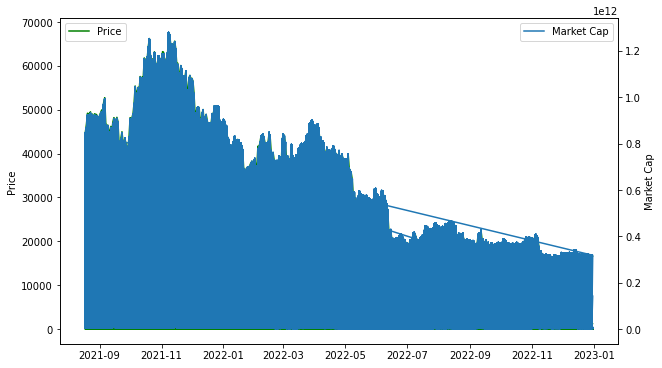

In [505]:
# data for the chart
x = df.index
y1 = df.Price
y2 = df.Market_Cap

# create the plot
fig, ax1 = plt.subplots()
# plot the first column on the left axis
ax1.plot(x, y1, label='Price', color = 'g')
ax1.set_ylabel('Price')

# create a second axis for the second column
ax2 = ax1.twinx()

# plot the second column on the right axis
ax2.plot(x, y2, label='Market Cap')
ax2.set_ylabel('Market Cap')

# add a legend
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# show the plot
plt.show()

In [509]:
nov = df.loc['11-01-22':]

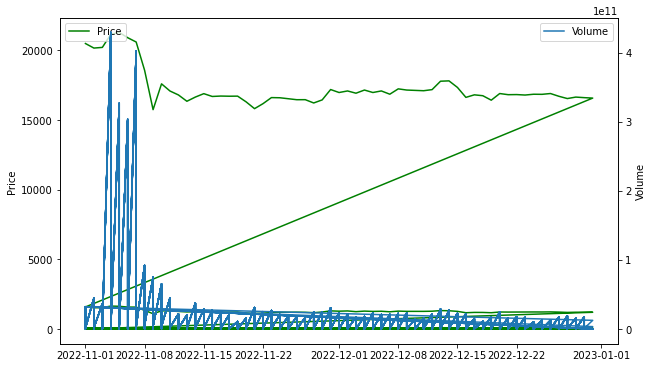

In [510]:
# data for the chart
x = nov.index
y1 = nov.Price
y2 = nov.Volume

# create the plot
fig, ax1 = plt.subplots()
# plot the first column on the left axis
ax1.plot(x, y1, label='Price', color = 'g')
ax1.set_ylabel('Price')

# create a second axis for the second column
ax2 = ax1.twinx()

# plot the second column on the right axis
ax2.plot(x, y2, label='Volume')
ax2.set_ylabel('Volume')

# add a legend
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# show the plot
plt.show()


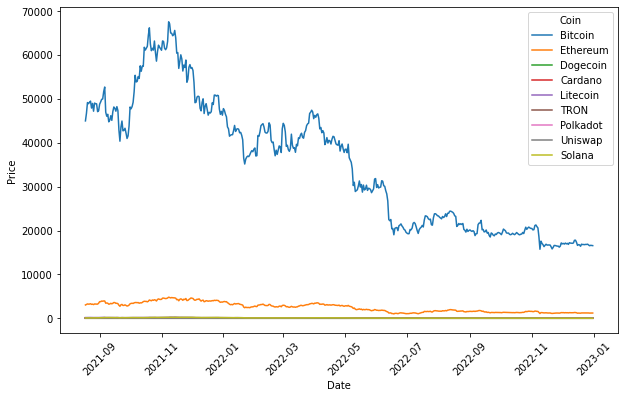

In [499]:
plt.rcParams['figure.figsize'] = (10, 6)

sns.lineplot(x=daily_df.index, y=daily_df['Price'], hue=daily_df['Coin'])
plt.xticks(rotation='45');

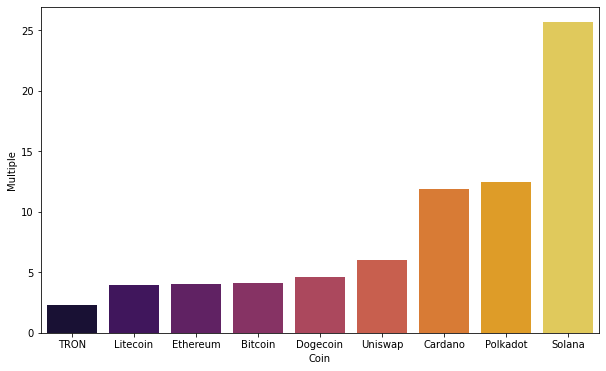

In [273]:
df1 = df.groupby('Coin')[['Multiple']].mean().sort_values(by='Multiple')

plt.rcParams['figure.figsize'] = (10, 6)

sns.barplot(data=df1, x=df1.index, y='Multiple', palette='inferno');

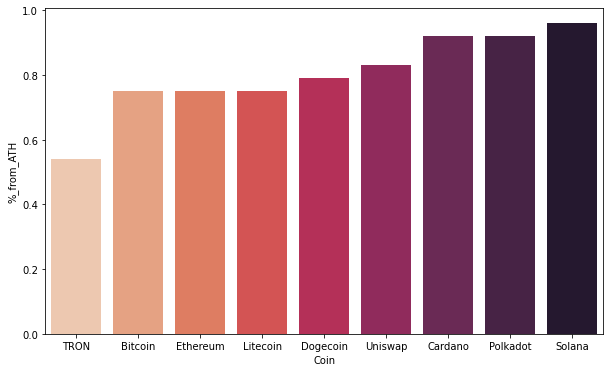

In [274]:
df2 = consolidated_df.groupby('Coin')[['%_from_ATH']].mean().sort_values(by='%_from_ATH')

plt.rcParams['figure.figsize'] = (10, 6)

sns.barplot(data=df2, x=df2.index, y='%_from_ATH', palette='rocket_r');

<AxesSubplot:>

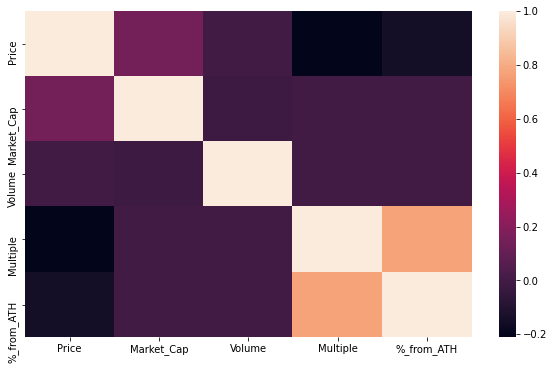

In [507]:
sns.heatmap(daily_df.corr())